In [1]:
import keras, csv, pickle, os, cv2
from keras import layers
from keras import backend as K
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
from keras.callbacks import ModelCheckpoint
import pandas as pd
from os.path import isfile, join
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


### Cropping the images

In [2]:
#using landmark annotations the pictures are cropped to the faces
land = pd.read_csv("./list_landmarks_align_celeba.csv")
dir_name = 'cropped/images'
if not os.path.exists(dir_name):
    os.makedirs(dir_name)

for i in range(len(land['image_id'])):
    img = land['image_id'][i]
    save_path = join(dir_name, img)
    if os.path.exists(save_path):
        continue
    path = join('img_align_celeba', img)
    img1 = cv2.imread(path)
    left_x = land['lefteye_x'][i]
    right_x = land['righteye_x'][i]
    nose_y = land['nose_y'][i]
    leftmouth_y = land['leftmouth_y'][i]
    cropped = img1[nose_y-105:leftmouth_y+35,left_x-50:right_x+50,:]
    if(np.array(cropped).nbytes > 0):
        cv2.imwrite(save_path, cropped)

### Load data generator and list of attributes

In [2]:
#initialize data generator for training(this is Keras' input pipepline for loading data from the harddrive) 
dataset_path = './cropped/'
datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_directory(dataset_path, target_size=(128,128), batch_size=20, class_mode='input')

Found 202593 images belonging to 1 classes.


In [3]:
df=pd.read_csv("./list_attr_celeba.csv")
attributes = df.columns.values[1:]

### Define VAE architecture

In [4]:
img_shape = (128, 128, 3)
latent_dim = 400

input_img = keras.Input(shape=img_shape) 

x = layers.Conv2D(64, 5, padding='same', activation='relu', strides=(2,2))(input_img)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, 5, padding='same', activation='relu', strides=(2,2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, 5, padding='same', activation='relu', strides=(2,2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(512, 5, padding='same', activation='relu', strides=(2,2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(1024, 2, padding='same', activation='relu', strides=(2,2))(x)
x = layers.BatchNormalization()(x)
shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x) 

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x) 
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(1024, 2, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(512, 5, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(256, 5, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(128, 5, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(64, 5, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(3, 5, padding='same', activation='sigmoid')(x)
decoder = Model(decoder_input, x)
encoder = Model(input_img, z)
z_decoded = decoder(z) 

def vae_loss(input_img, z_decoded):
    input_img = K.flatten(input_img)
    z_decoded = K.flatten(z_decoded)
    xent_loss = keras.metrics.binary_crossentropy(input_img, z_decoded) 
    kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

vae = Model(input_img, z_decoded)
vae.compile(optimizer='adam', loss=vae_loss)

### Train model or load weights

In [5]:
trained = 1

if(trained == 0):
    checkpointer = ModelCheckpoint(filepath='checkpoint.hdf5', verbose=2, save_best_only=False, save_weights_only=True)
    vae.fit_generator(train_generator,
        shuffle=True,
        steps_per_epoch = 10000,
        epochs=15,
        callbacks=[checkpointer],
        verbose=1
        )
else:
    vae.load_weights('checkpoint_celeba_cropped400.hdf5')

### Obtain concept vectors

In [6]:
latent_generator = datagen.flow_from_directory('cropped', target_size=(128,128), batch_size=100, shuffle=False)
filenames = latent_generator.filenames #list of filenames which matches list of latent vectors
latent = encoder.predict_generator(latent_generator, steps = 2000) 

num_samples = 500 #defines number of latent vectors used in averaging to obtain concept vector

# for each attribute two lists are created which contain all the pictures which either have this attribute or do not

avg_pos = []
avg_neg = []

idxs_pos = []
idxs_neg = []

for attr in attributes: 
    
    #lists to save indices of images with or without a certain attribute
    pos = []
    neg = []
    
    print(attr)
    
    for i in range(0, 180000):
        image_id = int(filenames[i][7:13])
        label = df[attr][image_id-1] # -1 to compensate zeroth row in df (indexing via row name is much slower) 
        
        #check labels for each picture and add to one of the lists accordingly
        if(label == 1):
            pos.append(i) 
        if(label == -1):
            neg.append(i)
        
    idxs_pos.append(pos)
    idxs_neg.append(neg)

    vectors_pos = latent[pos]
    vectors_neg = latent[neg]
    
    attr_avg_pos = np.average(vectors_pos[0:num_samples], axis = 0)
    attr_avg_neg = np.average(vectors_neg[0:num_samples], axis = 0)
    
    avg_pos.append(attr_avg_pos)
    avg_neg.append(attr_avg_neg)
    
avg_pos = np.array(avg_pos)
avg_neg = np.array(avg_neg)

concept_vectors = avg_pos - avg_neg

idx_pos = np.array(idxs_pos)
idx_neg = np.array(idxs_neg)

Found 202593 images belonging to 1 classes.


/home/kayoy/miniconda3/envs/bert_hw/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_v1.py:1301: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
/home/kayoy/miniconda3/envs/bert_hw/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


5_o_Clock_Shadow
Arched_Eyebrows
Attractive
Bags_Under_Eyes
Bald
Bangs
Big_Lips
Big_Nose
Black_Hair
Blond_Hair
Blurry
Brown_Hair
Bushy_Eyebrows
Chubby
Double_Chin
Eyeglasses
Goatee
Gray_Hair
Heavy_Makeup
High_Cheekbones
Male
Mouth_Slightly_Open
Mustache
Narrow_Eyes
No_Beard
Oval_Face
Pale_Skin
Pointy_Nose
Receding_Hairline
Rosy_Cheeks
Sideburns
Smiling
Straight_Hair
Wavy_Hair
Wearing_Earrings
Wearing_Hat
Wearing_Lipstick
Wearing_Necklace
Wearing_Necktie
Young


/home/kayoy/miniconda3/envs/bert_hw/lib/python3.7/site-packages/ipykernel_launcher.py:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/kayoy/miniconda3/envs/bert_hw/lib/python3.7/site-packages/ipykernel_launcher.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


### Dot products and histograms

In [7]:
dotp_pos = [] #will contain dot products(concept scores) of concept vectors and images that express this concept
dotp_neg = [] #will contain dot products(concept scores) of concept vectors and images that do not express this concept
for i, attr in enumerate(attributes):
    vectors_pos = latent[idxs_pos[i]]
    vectors_neg = latent[idxs_neg[i]]

    dotp_pos_attr = [np.sum(concept_vectors[i]*j) for j in vectors_pos]
    dotp_neg_attr = [np.sum(concept_vectors[i]*j) for j in vectors_neg]
    
    dotp_pos.append(dotp_pos_attr)
    dotp_neg.append(dotp_neg_attr)
    
dotp_pos = np.array(dotp_pos)
dotp_neg = np.array(dotp_neg)

/home/kayoy/miniconda3/envs/bert_hw/lib/python3.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]
/home/kayoy/miniconda3/envs/bert_hw/lib/python3.7/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [44]:
attributes

array(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair',
       'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee',
       'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male',
       'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair',
       'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'], dtype=object)

In [49]:
attributes_i

[array([15]), array([20]), array([6]), array([32])]

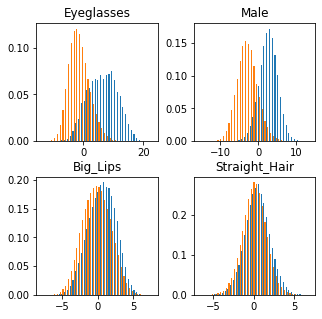

In [78]:
f, axs = plt.subplots(2,2, figsize=(5,5))

attributes_i = [np.where(attributes == "Eyeglasses")[0][0], np.where(attributes == "Male")[0][0], np.where(attributes == "Big_Lips")[0][0], np.where(attributes == "Straight_Hair")[0][0]]
i = 0
#plot the histograms to assess how well the concept scores are separated
for row in range(2):
    for column in range(2):
        j = attributes_i[i]
        axs[row, column].hist([dotp_pos[j], dotp_neg[j]], 40, density=True) 
        axs[row, column].title.set_text(attributes[j])
        i +=1

plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.savefig("concept_vector_hist_2.pdf", bbox_inches = 'tight',
    pad_inches = 0)

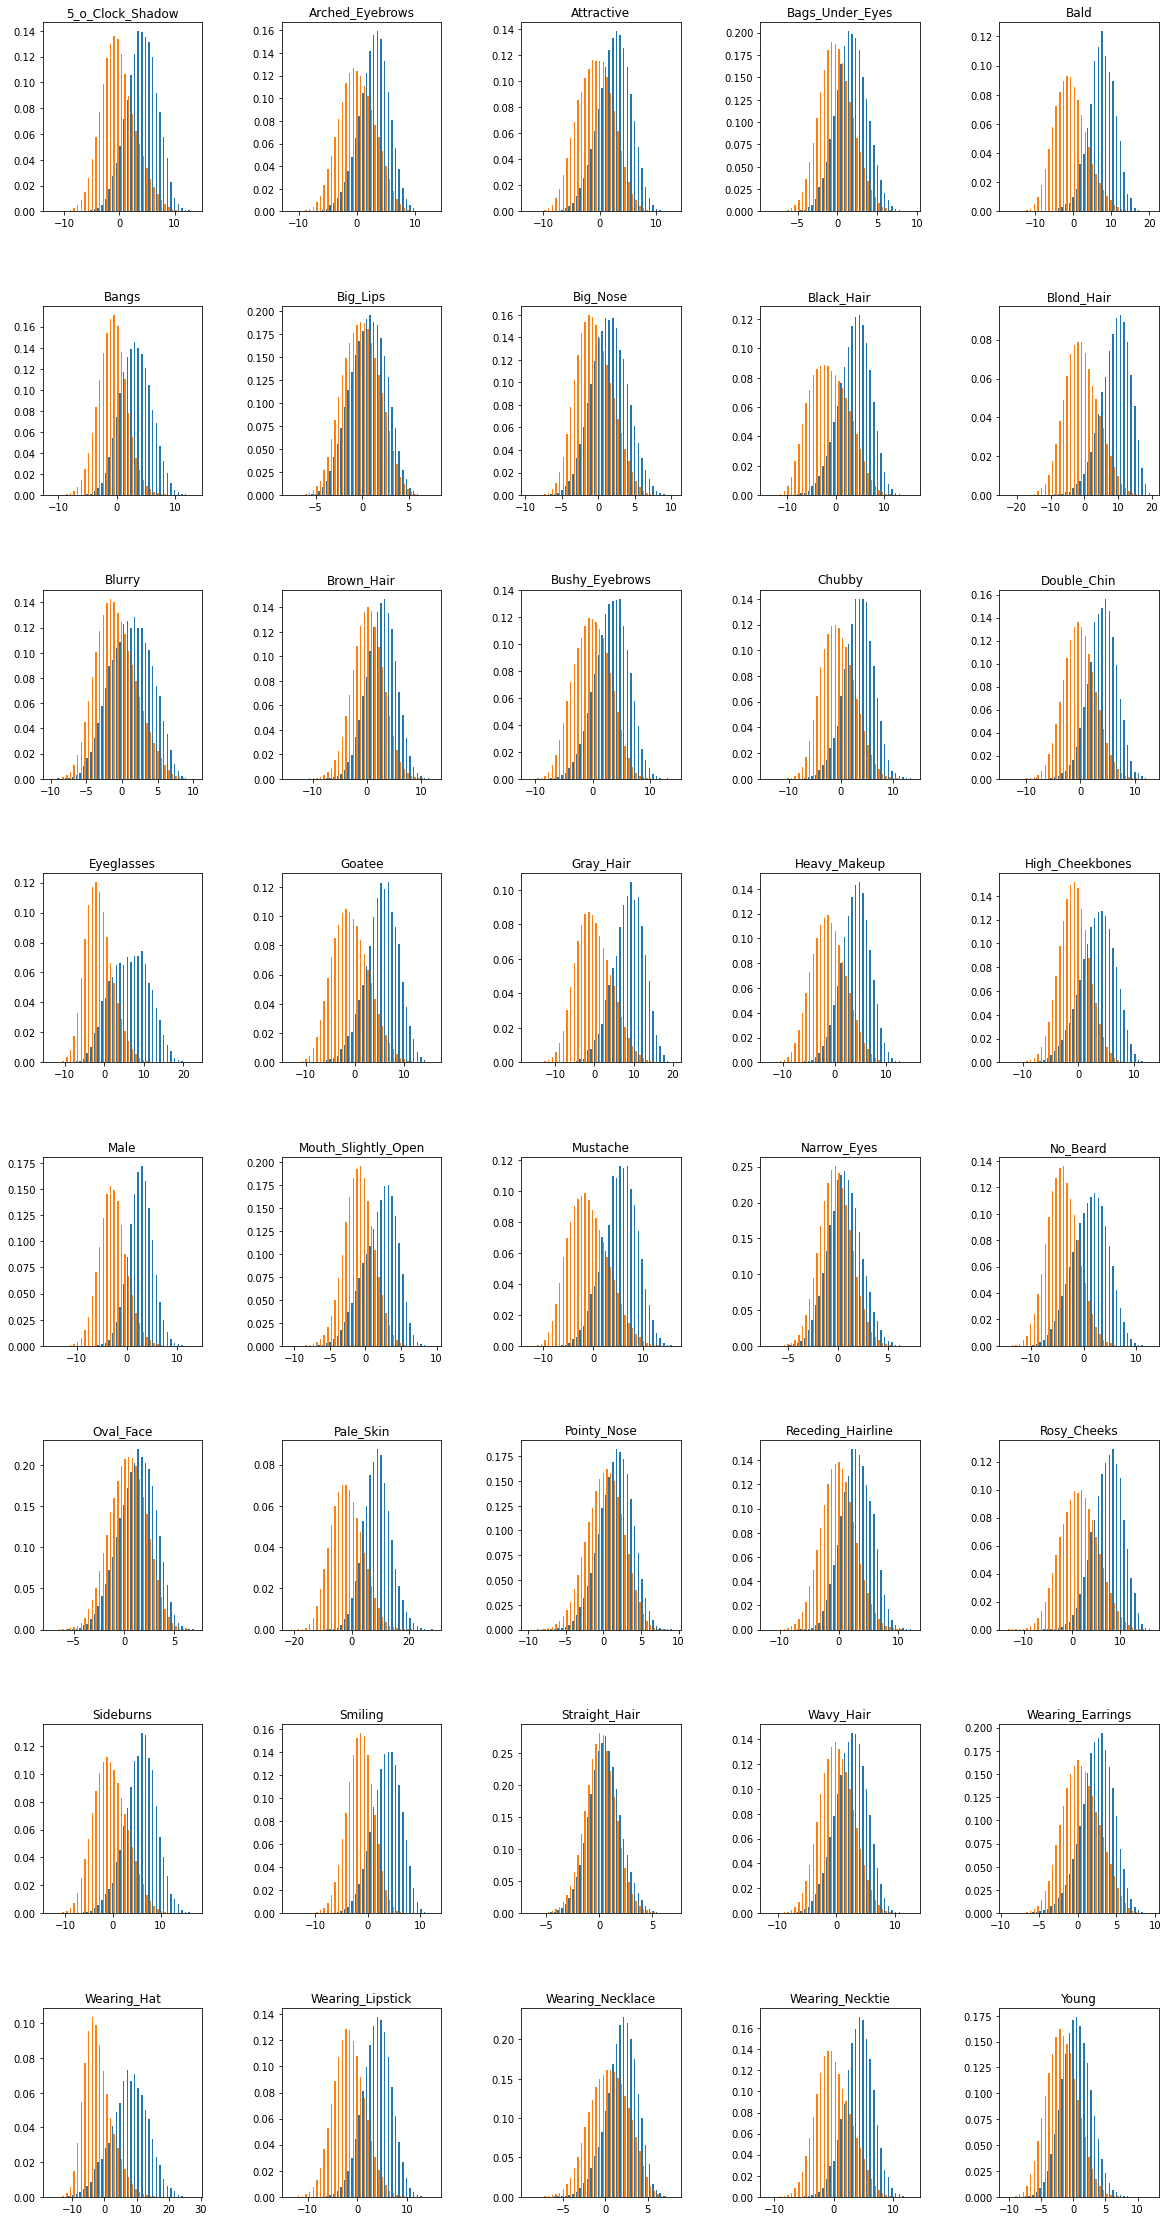

In [77]:
f, axs = plt.subplots(8,5, figsize=(20,40))

i = 0
#plot the histograms to assess how well the concept scores are separated
for row in range(8):
    for column in range(5):
        axs[row, column].hist([dotp_pos[i], dotp_neg[i]], 40, density=True) 
        axs[row, column].title.set_text(attributes[i])
        i +=1

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.savefig("concept_vector_hist.pdf", bbox_inches = 'tight',
    pad_inches = 0)

### Obtaining concept saliency maps

In [9]:
#choose image with high dot products for saliency maps
dotp_max = [list(reversed(np.array(i).argsort()))[2] for i in dotp_pos] 

In [10]:
#extract the filenames of the images with highest concept scores
files_max = []
for i, attr in enumerate(attributes):
    files_max.append(filenames[idxs_pos[i][dotp_max[i]]])
files_max = np.array(files_max)

In [79]:
#choose the attributes for which to plot saliency maps 
#attr = [4,12,15,21,31,35]
#attr = attributes_i
attr = [i for i in range(len(attributes))]

In [80]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

imgs = [load_img('cropped/'+i, target_size=(128, 128)) for i in files_max[attr]]
img_array = [img_to_array(i)/255.0 for i in imgs]

In [18]:
tf.sysconfig.get_lib()

'/home/kayoy/miniconda3/envs/bert_hw/lib/python3.7/site-packages/tensorflow'

In [32]:
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
import tensorflow.python.keras.backend as K

sess = K.get_session()
from deepexplain.tensorflow import DeepExplain
from deepexplain.utils import preprocess

#the implementation of the saliency map methods are taken from https://github.com/1202kbs/Rectified-Gradient
#de.explain(method, concept_score, input_tensor, img_array)
#available methods are:     
#    'rectgrad'
#    'rectgradprr'
#    'rectgradconst'
#    'saliency
#    'grad*input'
#    'deconv'
#    'guidedbp'
#    'smoothgrad'
#    'intgrad' (Integrated Gradients)
#    'elrp'    (EpsilonLRP)
#    'deeplift'
#    'occlusion'
#    'rectgradmod'
# input_tensor: placeholder tensor 
# img_array: contains the images which are fed into input_tensor

with DeepExplain(session=sess, graph=sess.graph) as de:
    
    input_tensor = input_img
    method = 'guidedbp'
    
    latents = encoder(input_tensor)

    concept_score = [K.sum(latents*i) for i in concept_vectors[attr]]
    attributions_guided = [de.explain(method, i, input_tensor, img_array) for i in concept_score]

/projects/tir4/users/kayoy/concept-saliency-maps/deepexplain/tensorflow/methods.py:737: UserWarning: DeepExplain detected you are trying to use an attribution method that requires gradient override but the original gradient was used instead. You might have forgot to (re)create your graph within the DeepExlain context. Results are not reliable!


In [82]:
with DeepExplain(session=sess, graph=sess.graph) as de:
    
    k = 95
    input_layer = input_img
    img = img_array
    method = 'rectgrad'
    
    lats = encoder(input_layer)

    class_neurons = [K.sum(lats*i) for i in concept_vectors[attr]]
    attributions_rect = [de.explain(method, i, input_layer, img, percentile=k) for i in class_neurons]

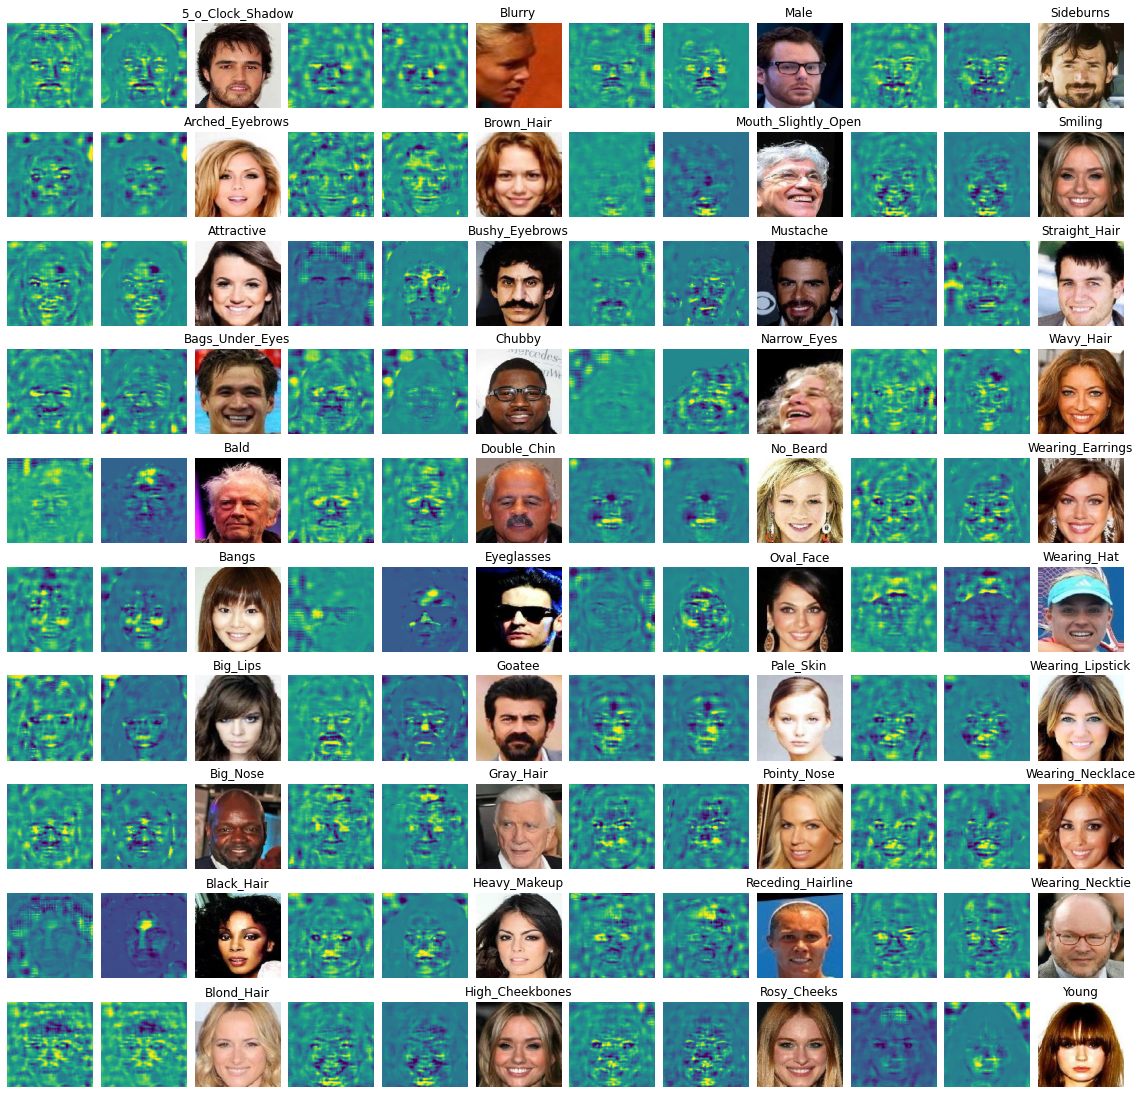

In [96]:
f, axs = plt.subplots(10,12,figsize=(20,20))

for j in range(10):
    att_guided = attributions_guided[j]
    att_rect = attributions_rect[j]
    axs[j,0].imshow(preprocess(att_guided,0.5,99.5)[j])
    axs[j,1].imshow(preprocess(att_rect,0.5,99.5)[j])
    axs[j,2].imshow(img_array[j])
    axs[j,0].axis('off')
    axs[j,1].axis('off')
    axs[j,2].axis('off')
    axs[j,2].title.set_text(attributes[attr[j]])
for j in range(10, 20):
    att_guided = attributions_guided[j]
    att_rect = attributions_rect[j]
    axs[j-10,0+3].imshow(preprocess(att_guided,0.5,99.5)[j])
    axs[j-10,1+3].imshow(preprocess(att_rect,0.5,99.5)[j])
    axs[j-10,2+3].imshow(img_array[j])
    axs[j-10,0+3].axis('off')
    axs[j-10,1+3].axis('off')
    axs[j-10,2+3].axis('off')
    axs[j-10,2+3].title.set_text(attributes[attr[j]])
for j in range(20, 30):
    att_guided = attributions_guided[j]
    att_rect = attributions_rect[j]
    axs[j-20,0+6].imshow(preprocess(att_guided,0.5,99.5)[j])
    axs[j-20,1+6].imshow(preprocess(att_rect,0.5,99.5)[j])
    axs[j-20,2+6].imshow(img_array[j])
    axs[j-20,0+6].axis('off')
    axs[j-20,1+6].axis('off')
    axs[j-20,2+6].axis('off')
    axs[j-20,2+6].title.set_text(attributes[attr[j]])
for j in range(30, 40):
    att_guided = attributions_guided[j]
    att_rect = attributions_rect[j]
    axs[j-30,0+9].imshow(preprocess(att_guided,0.5,99.5)[j])
    axs[j-30,1+9].imshow(preprocess(att_rect,0.5,99.5)[j])
    axs[j-30,2+9].imshow(img_array[j])
    axs[j-30,0+9].axis('off')
    axs[j-30,1+9].axis('off')
    axs[j-30,2+9].axis('off')
    axs[j-30,2+9].title.set_text(attributes[attr[j]])
plt.subplots_adjust(hspace=0, wspace=0.1)
plt.savefig("saliency_all.pdf", bbox_inches = 'tight',
    pad_inches = 0)

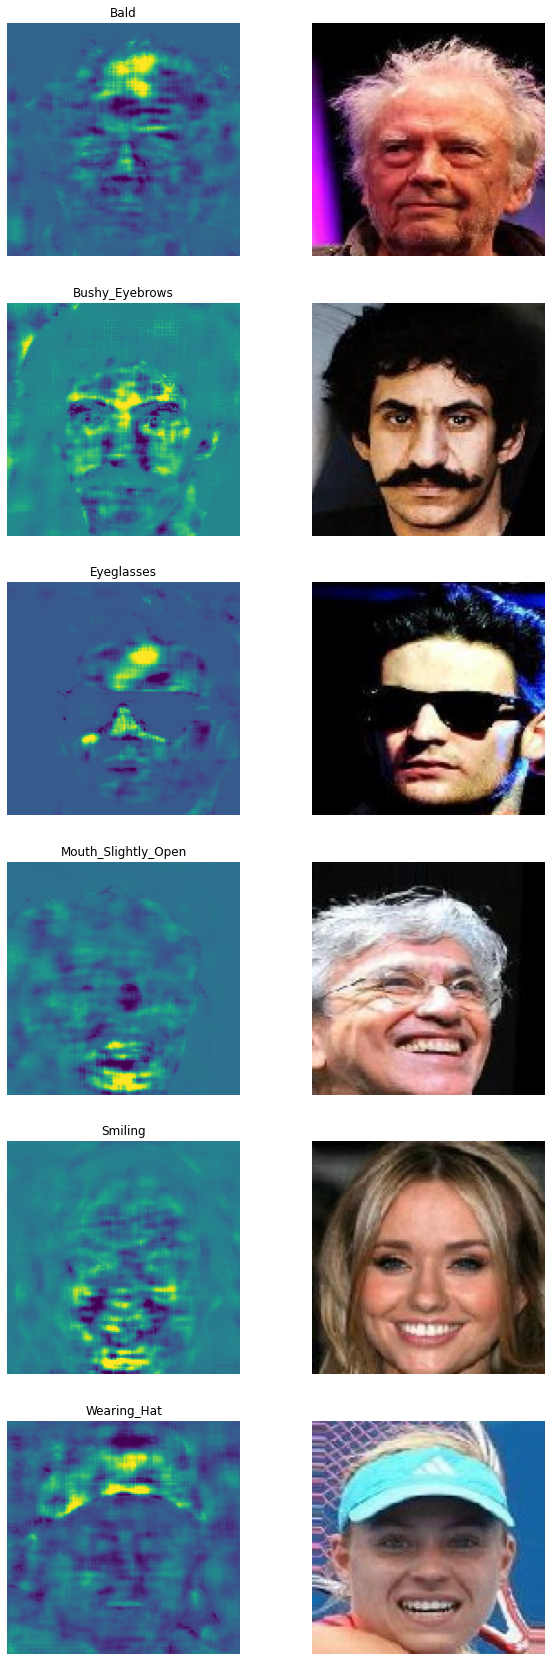

In [41]:
f, axs = plt.subplots(6,2,figsize=(10,30))

for j, attributions in enumerate(attributions_rect):
    axs[j,0].imshow(preprocess(attributions,0.5,99.5)[j])
    axs[j,1].imshow(img_array[j])
    axs[j,0].axis('off')
    axs[j,1].axis('off')
    axs[j,0].title.set_text(attributes[attr[j]])